# Discovering Topic-Based Subreddit Communities

> ##  Importing necessary libraries

In [56]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import networkx as nx
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from collections import Counter
import seaborn as sns
from textblob import TextBlob
from gensim.models.coherencemodel import CoherenceModel
import community
import networkx as nx
from community import community_louvain

> ## reading the dataset

In [57]:
df = pd.read_parquet('Reddit.parquet')
df.to_csv('Reddit.csv', index=False)

In [58]:
data=pd.read_csv('Reddit.csv')

In [59]:
data

,author,body,normalizedBody,subreddit,subreddit_id,id,content,summary
0,raysofdarkmatter,I think it should be fixed on either UTC stand...,I think it should be fixed on either UTC stand...,math,t5_2qh0n,c69al3r,I think it should be fixed on either UTC stand...,Shifting seasonal time is no longer worth it.
1,Stork13,Art is about the hardest thing to categorize i...,Art is about the hardest thing to categorize i...,funny,t5_2qh33,c6a9nxd,Art is about the hardest thing to categorize i...,Personal opinions 'n shit.
2,Cloud_dreamer,Ask me what I think about the Wall Street Jour...,Ask me what I think about the Wall Street Jour...,Borderlands,t5_2r8cd,c6acx4l,Ask me what I think about the Wall Street Jour...,insults and slack ass insight. \n Wall Street ...
3,NightlyReaper,"In Mechwarrior Online, I have begun to use a m...","In Mechwarrior Online, I have begun to use a m...",gamingpc,t5_2sq2y,c8onqew,"In Mechwarrior Online, I have begun to use a m...","Yes, Joysticks in modern games have apparently..."
4,NuffZetPand0ra,"You are talking about the Charsi imbue, right?...","You are talking about the Charsi imbue, right?...",Diablo,t5_2qore,c6acxvc,"You are talking about the Charsi imbue, right?...",Class only items dropped from high-lvl monsters.
...,...,...,...,...,...,...,...,...
132995,gopperman,"In my experience, dealing with the various asp...","In my experience, dealing with the various asp...",webdev,t5_2qs0q,cakkj0i,"In my experience, dealing with the various asp...","Either avoid the hassle, or make sure the clie..."
132996,Gimpy84,I had a high school English teacher who gave m...,I had a high school English teacher who gave m...,AdviceAnimals,t5_2s7tt,cakztnx,I had a high school English teacher who gave m...,I know what ubiquitous means now.
132997,floodster,Something really simple: Make a directory of e...,Something really simple: Make a directory of e...,rpg,t5_2qh2s,cal4oxl,Something really simple: Make a directory of e...,TV in the game room is great!
132998,user1492,"In order for an area to be occupied, the occup...","In order for an area to be occupied, the occup...",changemyview,t5_2w2s8,cal8j1u,"In order for an area to be occupied, the occup...",It's all Britain's fault.


In [60]:
dataset = pd.DataFrame(data)

new_order = ['id', 'author', 'body', 'normalizedBody', 'subreddit', 'subreddit_id', 'content', 'summary']
dataset = dataset[new_order]

dataset

,id,author,body,normalizedBody,subreddit,subreddit_id,content,summary
0,c69al3r,raysofdarkmatter,I think it should be fixed on either UTC stand...,I think it should be fixed on either UTC stand...,math,t5_2qh0n,I think it should be fixed on either UTC stand...,Shifting seasonal time is no longer worth it.
1,c6a9nxd,Stork13,Art is about the hardest thing to categorize i...,Art is about the hardest thing to categorize i...,funny,t5_2qh33,Art is about the hardest thing to categorize i...,Personal opinions 'n shit.
2,c6acx4l,Cloud_dreamer,Ask me what I think about the Wall Street Jour...,Ask me what I think about the Wall Street Jour...,Borderlands,t5_2r8cd,Ask me what I think about the Wall Street Jour...,insults and slack ass insight. \n Wall Street ...
3,c8onqew,NightlyReaper,"In Mechwarrior Online, I have begun to use a m...","In Mechwarrior Online, I have begun to use a m...",gamingpc,t5_2sq2y,"In Mechwarrior Online, I have begun to use a m...","Yes, Joysticks in modern games have apparently..."
4,c6acxvc,NuffZetPand0ra,"You are talking about the Charsi imbue, right?...","You are talking about the Charsi imbue, right?...",Diablo,t5_2qore,"You are talking about the Charsi imbue, right?...",Class only items dropped from high-lvl monsters.
...,...,...,...,...,...,...,...,...
132995,cakkj0i,gopperman,"In my experience, dealing with the various asp...","In my experience, dealing with the various asp...",webdev,t5_2qs0q,"In my experience, dealing with the various asp...","Either avoid the hassle, or make sure the clie..."
132996,cakztnx,Gimpy84,I had a high school English teacher who gave m...,I had a high school English teacher who gave m...,AdviceAnimals,t5_2s7tt,I had a high school English teacher who gave m...,I know what ubiquitous means now.
132997,cal4oxl,floodster,Something really simple: Make a directory of e...,Something really simple: Make a directory of e...,rpg,t5_2qh2s,Something really simple: Make a directory of e...,TV in the game room is great!
132998,cal8j1u,user1492,"In order for an area to be occupied, the occup...","In order for an area to be occupied, the occup...",changemyview,t5_2w2s8,"In order for an area to be occupied, the occup...",It's all Britain's fault.


## Exploratory data Analysis

> ### Handling NULL values

In [61]:
dataset.isnull().sum()

id                0
author            0
body              0
normalizedBody    0
subreddit         0
subreddit_id      0
content           0
summary           1
dtype: int64

In [62]:
dataset.dropna(subset=['summary'], inplace=True)

In [63]:
dataset.isnull().sum()

id                0
author            0
body              0
normalizedBody    0
subreddit         0
subreddit_id      0
content           0
summary           0
dtype: int64

In [64]:
dataset

,id,author,body,normalizedBody,subreddit,subreddit_id,content,summary
0,c69al3r,raysofdarkmatter,I think it should be fixed on either UTC stand...,I think it should be fixed on either UTC stand...,math,t5_2qh0n,I think it should be fixed on either UTC stand...,Shifting seasonal time is no longer worth it.
1,c6a9nxd,Stork13,Art is about the hardest thing to categorize i...,Art is about the hardest thing to categorize i...,funny,t5_2qh33,Art is about the hardest thing to categorize i...,Personal opinions 'n shit.
2,c6acx4l,Cloud_dreamer,Ask me what I think about the Wall Street Jour...,Ask me what I think about the Wall Street Jour...,Borderlands,t5_2r8cd,Ask me what I think about the Wall Street Jour...,insults and slack ass insight. \n Wall Street ...
3,c8onqew,NightlyReaper,"In Mechwarrior Online, I have begun to use a m...","In Mechwarrior Online, I have begun to use a m...",gamingpc,t5_2sq2y,"In Mechwarrior Online, I have begun to use a m...","Yes, Joysticks in modern games have apparently..."
4,c6acxvc,NuffZetPand0ra,"You are talking about the Charsi imbue, right?...","You are talking about the Charsi imbue, right?...",Diablo,t5_2qore,"You are talking about the Charsi imbue, right?...",Class only items dropped from high-lvl monsters.
...,...,...,...,...,...,...,...,...
132995,cakkj0i,gopperman,"In my experience, dealing with the various asp...","In my experience, dealing with the various asp...",webdev,t5_2qs0q,"In my experience, dealing with the various asp...","Either avoid the hassle, or make sure the clie..."
132996,cakztnx,Gimpy84,I had a high school English teacher who gave m...,I had a high school English teacher who gave m...,AdviceAnimals,t5_2s7tt,I had a high school English teacher who gave m...,I know what ubiquitous means now.
132997,cal4oxl,floodster,Something really simple: Make a directory of e...,Something really simple: Make a directory of e...,rpg,t5_2qh2s,Something really simple: Make a directory of e...,TV in the game room is great!
132998,cal8j1u,user1492,"In order for an area to be occupied, the occup...","In order for an area to be occupied, the occup...",changemyview,t5_2w2s8,"In order for an area to be occupied, the occup...",It's all Britain's fault.


In [65]:
dataset.describe()

,id,author,body,normalizedBody,subreddit,subreddit_id,content,summary
count,132999,132999,132999,132999,132999,132999,132999,132999
unique,132999,107123,132826,132807,5524,5524,132735,130757
top,c69al3r,DejaBoo,SHORT STORY TIME:\nI was at a ski hill with a ...,SHORT STORY TIME:\nI was at a ski hill with a ...,AskReddit,t5_2qh1i,SHORT STORY TIME:\nI was at a ski hill with a ...,No.
freq,1,56,17,17,31713,31713,17,105


- **author :**
  - Nombre unique d'auteurs : 107,123.
  - Auteur le plus fréquent : DejaBoo avec 56 occurrences.

- **body, normalizedBody, content :**
  - Nombre unique de corps de texte normalisé : 132,826 (pour body et normalizedBody, c'est le même nombre).
  - Le contenu le plus fréquent est un court récit ("SHORT STORY TIME:\nI was at a ski hill...") avec 17 occurrences.

- **subreddit, subreddit_id :**
  - Nombre unique de sous-forums : 5,524.
  - Le sous-forum le plus fréquent est AskReddit avec 31,713 occurrences.

- **id :**
  - Toutes les valeurs sont uniques, ce qui signifie que chaque ID est différent.

- **summary :**
  - Nombre unique de résumés : 130,757.
  - Le résumé le plus fréquent est "No." avec 105 occurrences.

In [66]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 132999 entries, 0 to 132999
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   id              132999 non-null  object
 1   author          132999 non-null  object
 2   body            132999 non-null  object
 3   normalizedBody  132999 non-null  object
 4   subreddit       132999 non-null  object
 5   subreddit_id    132999 non-null  object
 6   content         132999 non-null  object
 7   summary         132999 non-null  object
dtypes: object(8)
memory usage: 9.1+ MB


* The DataFrame consists of 132,999 entries indexed from 0 to 132,999.
* There are no missing values in any column (all columns have 132,999 non-null entries).
* The data type for each column is 'object', The columns contain text.
* The DataFrame consumes approximately 9.1 megabytes of memory.

> ### Top 10 Most Frequent Authors

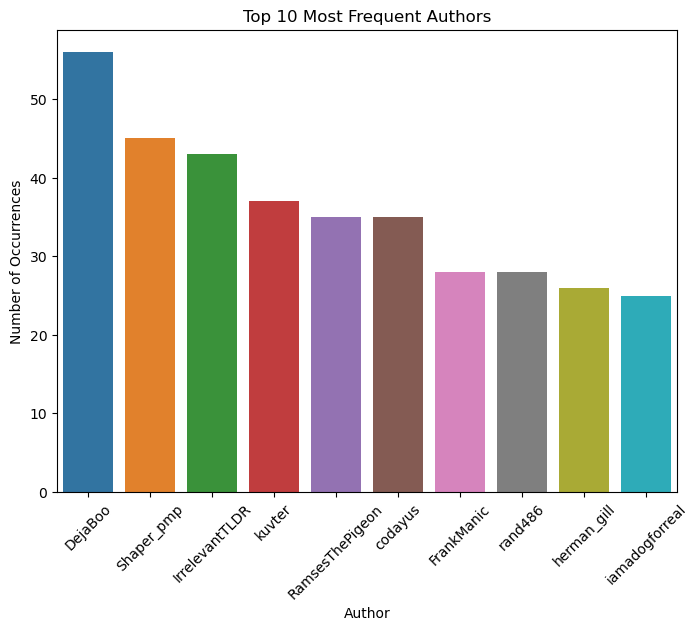

In [67]:
plt.figure(figsize=(8, 6))
top_authors = dataset['author'].value_counts().head(10)

sns.barplot(x=top_authors.index, y=top_authors.values)
plt.title('Top 10 Most Frequent Authors')
plt.xlabel('Author')
plt.ylabel('Number of Occurrences')
plt.xticks(rotation=45)
plt.show()


* **DejaBoo** : The most prolific author, appearing 56 times in the dataset.
* **Shaper_pmp** : Second in frequency, Shaper_pmp has 45 occurrences.
* **IrrelevantTLDR** : follows closely with 43 appearances.
* **kuvter** : is the fourth most frequent author with 37 occurrences.
* **RamsesThePigeon & codayus** : Sharing the fifth position, both authors have 35 occurrences.
* **FrankManic & rand486** : Tied for the seventh position, each has 28 occurrences.
* **herman_gill** : Ranked ninth, herman_gill appears 26 times.
* **iamadogforreal** : Completing the top 10,He is present 25 times.

> ### Top 10 Most Frequent Subreddits

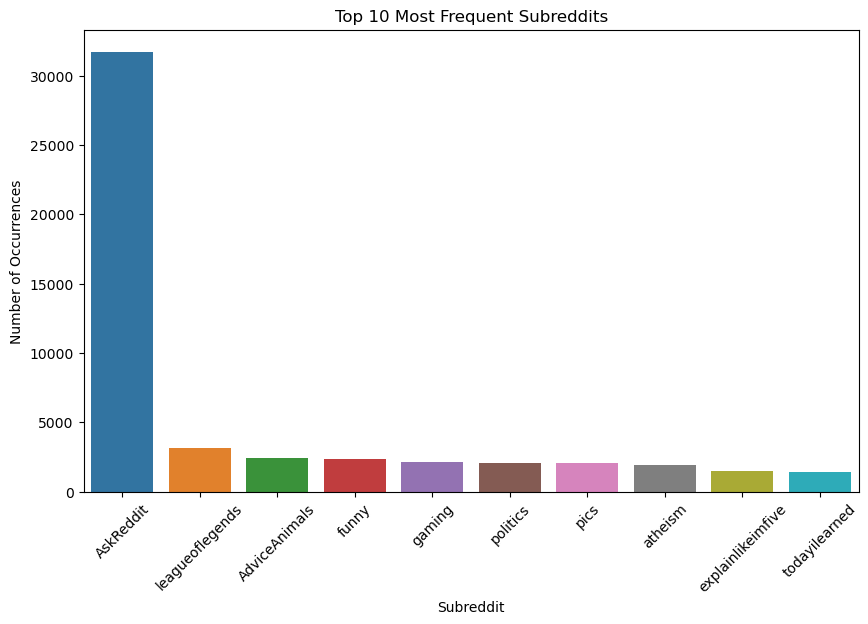

In [68]:
plt.figure(figsize=(10, 6))

top_subreddits = dataset['subreddit'].value_counts().head(10)

sns.barplot(x=top_subreddits.index, y=top_subreddits.values)
plt.title('Top 10 Most Frequent Subreddits')
plt.xlabel('Subreddit')
plt.ylabel('Number of Occurrences')
plt.xticks(rotation=45)
plt.show()

* **AskReddit** (31,713): Dominating with the highest post count, AskReddit is a widely popular subreddit.
* **leagueoflegends** (3,148): Second in frequency, leagueoflegends caters to the gaming community.
* **AdviceAnimals** (2,464): Holding the third spot, AdviceAnimals is a subreddit for humorous and relatable images.
* **funny** (2,351): The fourth most frequent, funny features a variety of comedic content.
* **gaming** (2,126): Ranking fifth, gaming is a hub for discussions on various video games.
* **politics** (2,074): In the sixth position, politics gathers discussions on political topics.
* **pics** (2,044): Seventh in frequency, pics is a subreddit for sharing and discussing images.
* **atheism** (1,907): Atheism, ranking eighth, focuses on discussions related to atheism and secular living.
* **explainlikeimfive** (1,512): Ninth in frequency, explainlikeimfive is a subreddit for simplified explanations of complex topics.
* **todayilearned** (1,412): Completing the top 10, todayilearned features posts sharing interesting facts learned by users.


>  >  * We will work only with 10000 examples of data , because of our hardwares capabilities.

In [71]:
df = dataset[:10001]

In [72]:
df

,id,author,body,normalizedBody,subreddit,subreddit_id,content,summary
0,c69al3r,raysofdarkmatter,I think it should be fixed on either UTC stand...,I think it should be fixed on either UTC stand...,math,t5_2qh0n,I think it should be fixed on either UTC stand...,Shifting seasonal time is no longer worth it.
1,c6a9nxd,Stork13,Art is about the hardest thing to categorize i...,Art is about the hardest thing to categorize i...,funny,t5_2qh33,Art is about the hardest thing to categorize i...,Personal opinions 'n shit.
2,c6acx4l,Cloud_dreamer,Ask me what I think about the Wall Street Jour...,Ask me what I think about the Wall Street Jour...,Borderlands,t5_2r8cd,Ask me what I think about the Wall Street Jour...,insults and slack ass insight. \n Wall Street ...
3,c8onqew,NightlyReaper,"In Mechwarrior Online, I have begun to use a m...","In Mechwarrior Online, I have begun to use a m...",gamingpc,t5_2sq2y,"In Mechwarrior Online, I have begun to use a m...","Yes, Joysticks in modern games have apparently..."
4,c6acxvc,NuffZetPand0ra,"You are talking about the Charsi imbue, right?...","You are talking about the Charsi imbue, right?...",Diablo,t5_2qore,"You are talking about the Charsi imbue, right?...",Class only items dropped from high-lvl monsters.
...,...,...,...,...,...,...,...,...
9996,c5g333y,watching_Idol,I am probably too late. \nLast year a group of...,I am probably too late. \nLast year a group of...,AskReddit,t5_2qh1i,I am probably too late. \nLast year a group of...,The owner was an asshole.
9997,c5g38hx,FlossingWithYarn,"Not nearly as bad as yours, but here goes: my ...","Not nearly as bad as yours, but here goes: my ...",AskReddit,t5_2qh1i,"Not nearly as bad as yours, but here goes: my ...",Friend and I missed a concert because the pers...
9998,c5g38s9,jemologist,More than likely going to get buried but wth....,More than likely going to get buried but wth....,AskReddit,t5_2qh1i,More than likely going to get buried but wth....,"didnt tip,bartender called me a bitch and cont..."
9999,c5g391y,KnicknackJack,"Sorry, this is kinda long, but there's a lot o...","Sorry, this is kinda long, but there's a lot o...",AskReddit,t5_2qh1i,"Sorry, this is kinda long, but there's a lot o...","Went for karaoke with large group, got poor se..."


## Preprocessing text data

In [53]:
pip install langid



     ---------------------------------------- 0.0/1.9 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.9 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.9 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.9 MB ? eta -:--:--
      --------------------------------------- 0.0/1.9 MB 163.8 kB/s eta 0:00:12
      --------------------------------------- 0.0/1.9 MB 164.3 kB/s eta 0:00:12
     - -------------------------------------- 0.1/1.9 MB 231.8 kB/s eta 0:00:08
     -- ------------------------------------- 0.1/1.9 MB 379.3 kB/s eta 0:00:05
     ---- ----------------------------------- 0.2/1.9 MB 565.6 kB/s eta 0:00:04
     ----- ---------------------------------- 0.3/1.9 MB 682.7 kB/s eta 0:00:03
     ----- ---------------------------------- 0.3/1.9 MB 682.7 kB/s eta 0:00:03
     ------- -------------------------------- 0.3/1.9 MB 677.0 kB/s eta 0:00:03
     ---------- ----------------------------- 0.5/1.9 MB 906.4 kB/s eta 0:0

In [73]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
import langid

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  
    
def is_english(word):
    # Check if the word is English using langid
    lang, confidence = langid.classify(word)
    return lang == 'en' and confidence > 0.8  

def clean(text):
    wn = WordNetLemmatizer()

    # Tokenize the text
    tokens = word_tokenize(text)

    # Lemmatization and removing non-alphabetic words
    lem_text = [wn.lemmatize(word, pos=get_wordnet_pos(pos)) for word, pos in pos_tag(tokens) if word.isalpha()]

    # Lowercase all words
    lower_text = [word.lower() for word in lem_text]

    # Define stop words
    stop_wds = set(stopwords.words('english'))

    # Additional common words to remove
    additional_stop_words = set(["said", "wa", "ha", "could", "would", "may", "one", "get", "like", "also", "even", "make"])

    # Remove stop words and additional common words
    clean_text = [word for word in lower_text if word not in (stop_wds | additional_stop_words) and is_english(word)]

    clean_string = ' '.join(clean_text)

    return clean_string


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [74]:
import time
start = time.time()
df['cleaned_content'] = df['content'].apply(clean)
end = time.time()
print(end-start)

4774.1848266124725


C:\Users\admin\AppData\Local\Temp\ipykernel_15648\1982346867.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cleaned_content'] = df['content'].apply(clean)


In [75]:
df

,id,author,body,normalizedBody,subreddit,subreddit_id,content,summary,cleaned_content
0,c69al3r,raysofdarkmatter,I think it should be fixed on either UTC stand...,I think it should be fixed on either UTC stand...,math,t5_2qh0n,I think it should be fixed on either UTC stand...,Shifting seasonal time is no longer worth it.,think fix utc standard year around current zon...
1,c6a9nxd,Stork13,Art is about the hardest thing to categorize i...,Art is about the hardest thing to categorize i...,funny,t5_2qh33,Art is about the hardest thing to categorize i...,Personal opinions 'n shit.,art hard categorize term good bad consider wor...
2,c6acx4l,Cloud_dreamer,Ask me what I think about the Wall Street Jour...,Ask me what I think about the Wall Street Jour...,Borderlands,t5_2r8cd,Ask me what I think about the Wall Street Jour...,insults and slack ass insight. \n Wall Street ...,ask think wall street tell bland monumental wa...
3,c8onqew,NightlyReaper,"In Mechwarrior Online, I have begun to use a m...","In Mechwarrior Online, I have begun to use a m...",gamingpc,t5_2sq2y,"In Mechwarrior Online, I have begun to use a m...","Yes, Joysticks in modern games have apparently...",online begin use mouse turret aspect torso log...
4,c6acxvc,NuffZetPand0ra,"You are talking about the Charsi imbue, right?...","You are talking about the Charsi imbue, right?...",Diablo,t5_2qore,"You are talking about the Charsi imbue, right?...",Class only items dropped from high-lvl monsters.,talk charsi right cube upgrade talk charsi whi...
...,...,...,...,...,...,...,...,...,...
9996,c5g333y,watching_Idol,I am probably too late. \nLast year a group of...,I am probably too late. \nLast year a group of...,AskReddit,t5_2qh1i,I am probably too late. \nLast year a group of...,The owner was an asshole.,late last year group u go fl vacation go well ...
9997,c5g38hx,FlossingWithYarn,"Not nearly as bad as yours, but here goes: my ...","Not nearly as bad as yours, but here goes: my ...",AskReddit,t5_2qh1i,"Not nearly as bad as yours, but here goes: my ...",Friend and I missed a concert because the pers...,nearly bad go friend go go concert time check ...
9998,c5g38s9,jemologist,More than likely going to get buried but wth....,More than likely going to get buried but wth....,AskReddit,t5_2qh1i,More than likely going to get buried but wth....,"didnt tip,bartender called me a bitch and cont...",likely go bury wth month job great friend deci...
9999,c5g391y,KnicknackJack,"Sorry, this is kinda long, but there's a lot o...","Sorry, this is kinda long, but there's a lot o...",AskReddit,t5_2qh1i,"Sorry, this is kinda long, but there's a lot o...","Went for karaoke with large group, got poor se...",sorry kinda long lot info include new place op...


> ## WordCloud vizualisation of the cleaned_content column

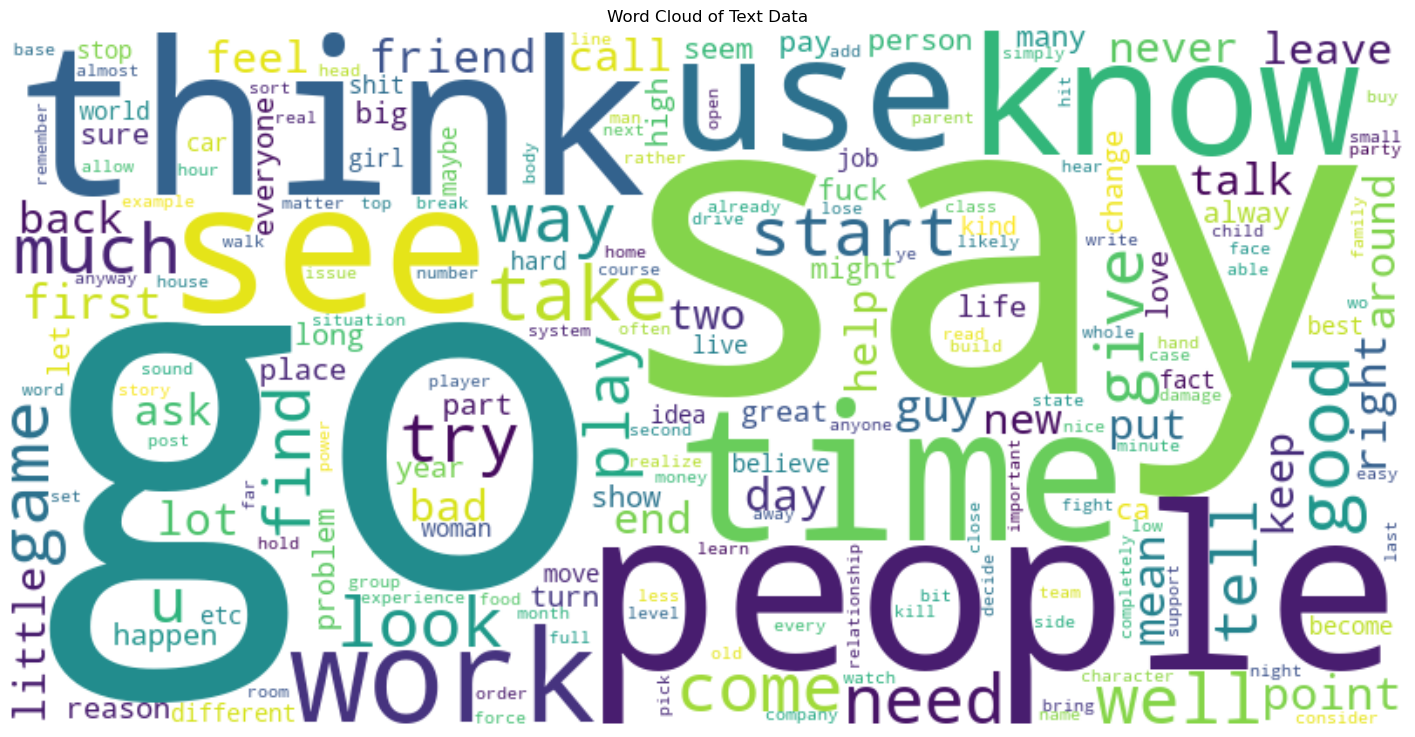

In [76]:
text = ' '.join(df['cleaned_content'].astype(str))

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(18, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Text Data')
plt.show()

> ## Top 20 most frequent words in cleaned_content column

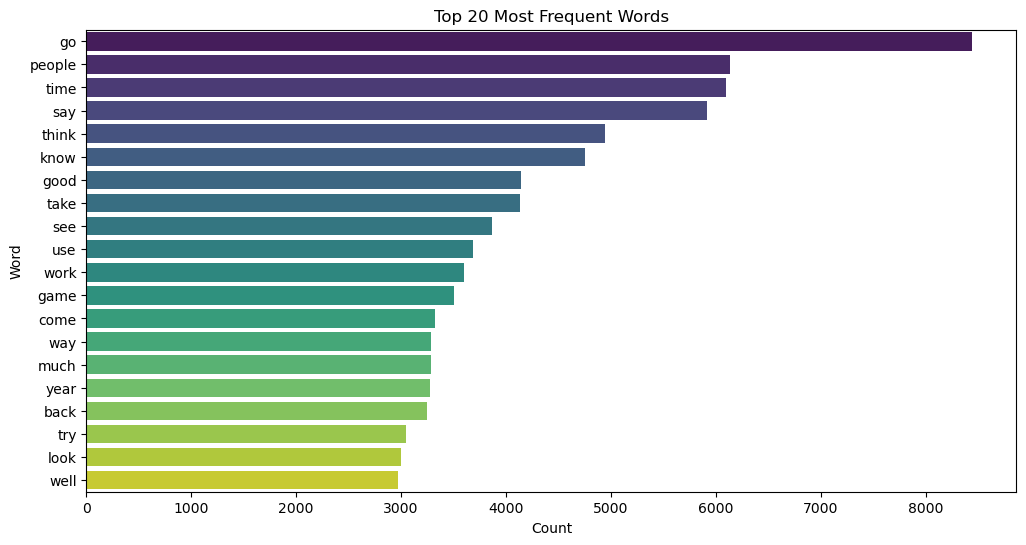

In [77]:
words = ' '.join(df['cleaned_content'].astype(str)).split()
word_counts = Counter(words)

word_counts_df = pd.DataFrame(word_counts.most_common(20), columns=['Word', 'Count'])

plt.figure(figsize=(12, 6))
sns.barplot(x='Count', y='Word', data=word_counts_df, palette='viridis')
plt.title('Top 20 Most Frequent Words')
plt.show()

> ## Sentiment Scores in cleaned_content column

C:\Users\admin\AppData\Local\Temp\ipykernel_15648\1669042943.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sentiment'] = df['cleaned_content'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)


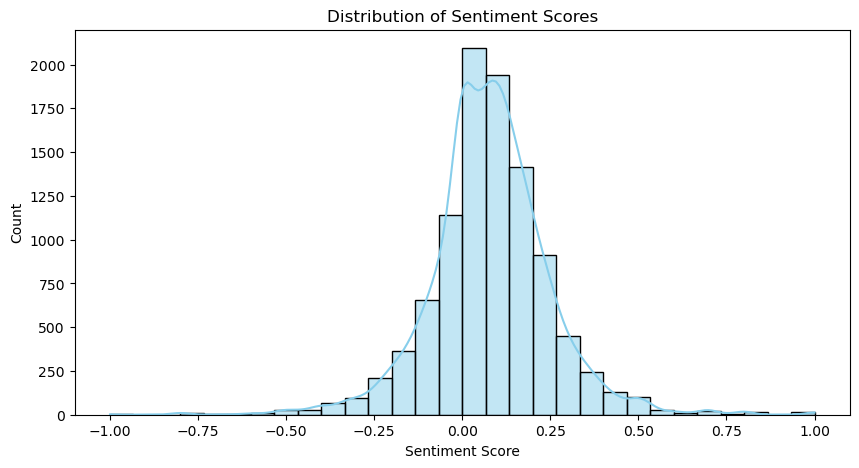

In [78]:
df['Sentiment'] = df['cleaned_content'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# Plot the distribution of sentiment scores
plt.figure(figsize=(10, 5))
sns.histplot(df['Sentiment'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.show()

* The histogram of sentiment scores reveals that the majority of the
text data tends to have neutral to positive sentiments, as indicated
by scores around 0 or greater. However, the presence of negative
values suggests that there are instances of negative sentiment
within the dataset. This distribution provides an overview of the
overall sentiment tendencies, with potential nuances captured by
the range of scores.

# TOPIC MODELING 

> ## Applying Topic modeling using Latent Dirichlet Allocation (LDA) 

#### Determine the optimial number of topics:

*  Perplexity: A measure of how well LDA predicts words in a document. Lower perplexity values indicate better model performance, but it may not always align perfectly with topic interpretability.
* Coherence: Assesses the semantic similarity between high-scoring words within a topic. Higher coherence scores indicate more interpretable topics, aligning closely with human interpretability compared to perplexity.

Optimal Number of Topics: 12
Perplexity Score for Optimal Topics: -8.335657862570189
Coherence Score for Optimal Topics: 0.41535796989055557

Topics:
Topic 1: 0.012*"work" + 0.010*"money" + 0.009*"people" + 0.008*"pay" + 0.008*"year" + 0.007*"company" + 0.007*"use" + 0.007*"need" + 0.006*"much" + 0.006*"job"
Topic 2: 0.024*"car" + 0.022*"lane" + 0.016*"champion" + 0.012*"ad" + 0.009*"characteristic" + 0.009*"q" + 0.008*"adc" + 0.008*"champ" + 0.008*"passive" + 0.007*"solo"
Topic 3: 0.017*"character" + 0.015*"show" + 0.014*"music" + 0.012*"movie" + 0.011*"watch" + 0.010*"de" + 0.010*"book" + 0.009*"fan" + 0.008*"love" + 0.008*"story"
Topic 4: 0.510*"instruct" + 0.025*"season" + 0.004*"tub" + 0.003*"tow" + 0.003*"cinnamon" + 0.003*"highway" + 0.003*"bath" + 0.002*"alt" + 0.002*"lens" + 0.002*"cocaine"
Topic 5: 0.042*"game" + 0.027*"play" + 0.012*"player" + 0.012*"team" + 0.012*"good" + 0.010*"time" + 0.008*"much" + 0.008*"damage" + 0.008*"go" + 0.008*"use"
Topic 6: 0.041*"girl" + 0.032*"

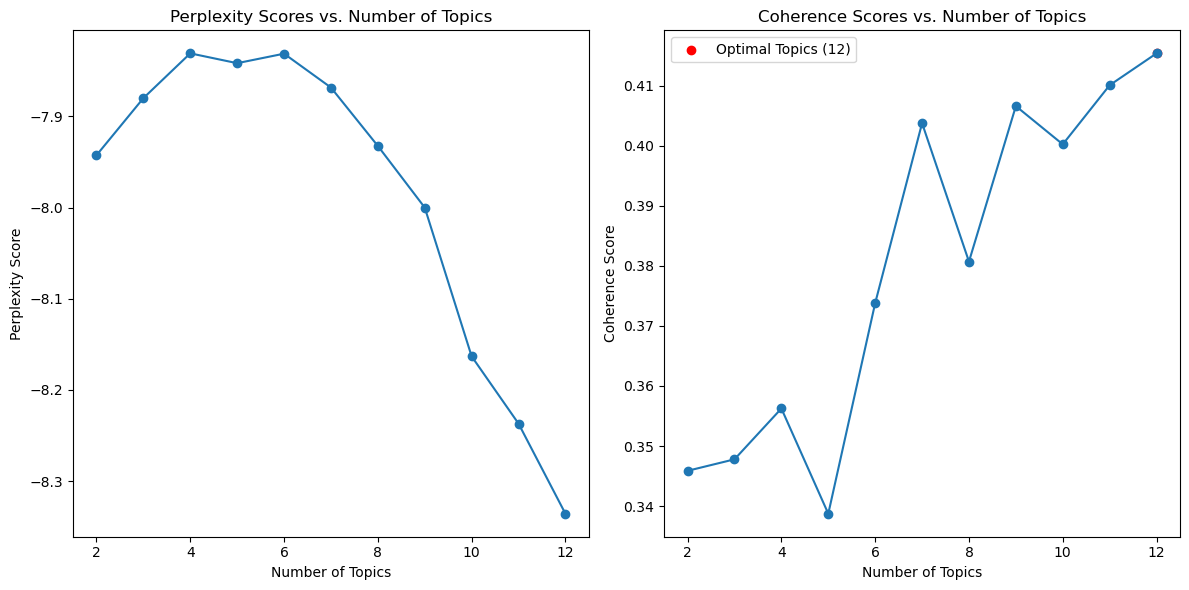

In [80]:
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

documents_as_lists = [doc.split() for doc in df['cleaned_content'].tolist()]


dictionary = Dictionary(documents_as_lists)

corpus = [dictionary.doc2bow(doc) for doc in documents_as_lists]

num_topics_range = range(2, 13)

perplexity_scores = []
coherence_scores = []

for num_topics in num_topics_range:
  
    lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10)
    
   
    perplexity = lda_model.log_perplexity(corpus)
    perplexity_scores.append(perplexity)
    
    
    coherence_model = CoherenceModel(model=lda_model, texts=documents_as_lists, dictionary=dictionary, coherence='c_v')
    coherence = coherence_model.get_coherence()
    coherence_scores.append(coherence)


optimal_num_topics = num_topics_range[coherence_scores.index(max(coherence_scores))]


print(f"Optimal Number of Topics: {optimal_num_topics}")
print(f"Perplexity Score for Optimal Topics: {perplexity_scores[optimal_num_topics - 2]}")  
print(f"Coherence Score for Optimal Topics: {max(coherence_scores)}")

optimal_lda_model = LdaModel(corpus, num_topics=optimal_num_topics, id2word=dictionary, passes=10)


print("\nTopics:")
for topic_id, topic in optimal_lda_model.show_topics(num_topics=optimal_num_topics, num_words=5, formatted=False):
    words = [word for word, _ in topic]
    print(f"Topic {topic_id + 1}: {', '.join(words)}")

# Plot the perplexity and coherence scores
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(num_topics_range, perplexity_scores, marker='o')
plt.title('Perplexity Scores vs. Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity Score')

plt.subplot(1, 2, 2)
plt.plot(num_topics_range, coherence_scores, marker='o')
plt.title('Coherence Scores vs. Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')


#the optimal number of topics
plt.scatter(optimal_num_topics, max(coherence_scores), color='red', label=f'Optimal Topics ({optimal_num_topics})')
plt.legend()

plt.tight_layout()
plt.show()


> ## Applying Topic modeling using NMF(Non-Negative Matrix Factorization)

C:\Users\admin\anaconda3\Lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\admin\anaconda3\Lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Optimal Number of Topics: 12
Reconstruction Error for Optimal Topics: 97.18460841484222

Topics:
(0, '0.955*" good", 0.921*" think", 0.905*" use", 0.762*" feel", 0.749*" need"')
(1, '2.509*" game", 0.457*" play", 0.247*" fun", 0.174*" new", 0.172*" character"')
(2, '2.071*" friend", 1.111*" girl", 0.579*" guy", 0.562*" date", 0.433*" talk"')
(3, '1.037*" pay", 0.836*" money", 0.814*" work", 0.619*" job", 0.595*" company"')
(4, '2.068*" car", 0.608*" drive", 0.452*" cop", 0.263*" driver", 0.247*" park"')
(5, '2.888*" people", 0.357*" person", 0.244*" black", 0.241*" white", 0.231*" group"')
(6, '1.993*" say", 0.837*" tell", 0.687*" ask", 0.625*" know", 0.387*" guy"')
(7, '1.632*" woman", 0.840*" men", 0.394*" sex", 0.374*" man", 0.309*" gay"')
(8, '1.608*" year", 0.714*" love", 0.676*" parent", 0.649*" old", 0.499*" family"')
(9, '1.170*" day", 0.724*" time", 0.566*" start", 0.536*" hour", 0.492*" week"')
(10, '1.637*" post", 1.114*" read", 0.677*" comment", 0.391*" link", 0.215*" artic

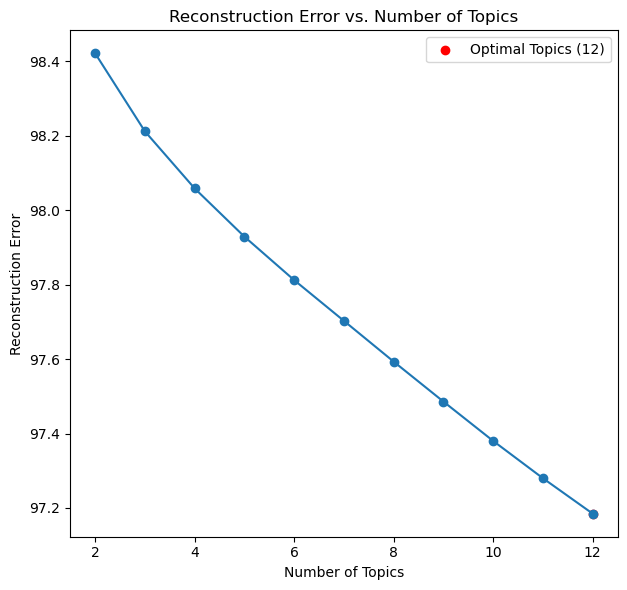

In [81]:
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt


documents = df['cleaned_content'].tolist()

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(documents)

num_topics_range = range(2, 13)

reconstruction_errors = []
nmf_models = []

for num_topics in num_topics_range:
    nmf_model = NMF(n_components=num_topics, random_state=42)
    nmf_topic_matrix = nmf_model.fit_transform(tfidf_matrix)
    
    reconstruction_error = nmf_model.reconstruction_err_
    reconstruction_errors.append(reconstruction_error)
    
    nmf_models.append(nmf_model)

optimal_num_topics = num_topics_range[reconstruction_errors.index(min(reconstruction_errors))]

print(f"Optimal Number of Topics: {optimal_num_topics}")
print(f"Reconstruction Error for Optimal Topics: {min(reconstruction_errors)}")

optimal_nmf_model = nmf_models[num_topics_range.index(optimal_num_topics)]

feature_names = tfidf_vectorizer.get_feature_names_out()

print("\nTopics:")
for i, topic in enumerate(optimal_nmf_model.components_):
    top_words_idx = topic.argsort()[:-5-1:-1]
    top_words = [feature_names[idx] for idx in top_words_idx]
    topic_str = ', '.join([f'{weight:.3f}*" {word}"' for word, weight in zip(top_words, topic[top_words_idx])])
    print(f"({i}, '{topic_str}')")

# Plot the reconstruction error
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(num_topics_range, reconstruction_errors, marker='o')
plt.title('Reconstruction Error vs. Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Reconstruction Error')

#the optimal number of topics
plt.scatter(optimal_num_topics, min(reconstruction_errors), color='red', label=f'Optimal Topics ({optimal_num_topics})')
plt.legend()

plt.tight_layout()
plt.show()


> ## Applying Topic modeling using LSA (Latent Semantic Analysis)

Optimal Number of Topics: 12
Explained Variance for Optimal Topics: 0.15562567825881535

Topics:
(0, '0.273*" people", 0.269*" time", 0.263*" say", 0.217*" know", 0.209*" think"')
(1, '0.806*" game", 0.251*" play", 0.226*" characteristic", 0.140*" entity", 0.136*" second"')
(2, '0.723*" people", 0.102*" good", 0.080*" use", 0.076*" think", 0.075*" mean"')
(3, '0.436*" say", 0.278*" people", 0.205*" friend", 0.176*" tell", 0.140*" game"')
(4, '0.715*" car", 0.231*" characteristic", 0.151*" people", 0.137*" entity", 0.135*" second"')
(5, '0.375*" say", 0.282*" use", 0.179*" work", 0.166*" characteristic", 0.123*" need"')
(6, '0.284*" time", 0.268*" work", 0.262*" year", 0.227*" people", 0.187*" day"')
(7, '0.318*" think", 0.265*" characteristic", 0.213*" feel", 0.178*" second", 0.164*" entity"')
(8, '0.416*" time", 0.294*" use", 0.189*" people", 0.157*" computer", 0.129*" know"')
(9, '0.328*" know", 0.223*" friend", 0.216*" use", 0.207*" work", 0.177*" guy"')
(10, '0.340*" know", 0.319*"

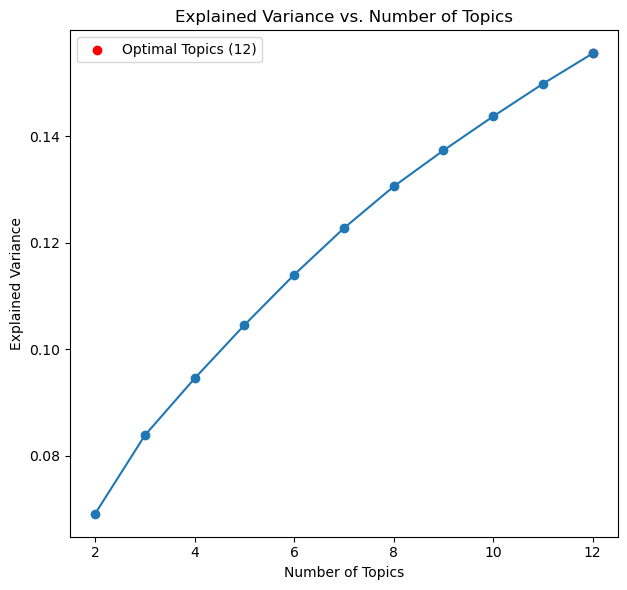

In [82]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

documents = df['cleaned_content'].tolist()

vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(documents)

num_topics_range = range(2, 13)

explained_variances = []
lsa_models = []

for num_topics in num_topics_range:
 
    lsa_model = TruncatedSVD(n_components=num_topics, random_state=42)
    lsa_topic_matrix = lsa_model.fit_transform(dtm)

    explained_variance = lsa_model.explained_variance_ratio_.sum()
    explained_variances.append(explained_variance)
 
    lsa_models.append(lsa_model)

optimal_num_topics = num_topics_range[explained_variances.index(max(explained_variances))]


print(f"Optimal Number of Topics: {optimal_num_topics}")
print(f"Explained Variance for Optimal Topics: {max(explained_variances)}")

optimal_lsa_model = lsa_models[num_topics_range.index(optimal_num_topics)]

feature_names = vectorizer.get_feature_names_out()

print("\nTopics:")
for i, topic in enumerate(optimal_lsa_model.components_):
    top_words_idx = topic.argsort()[:-5-1:-1]
    top_words = [feature_names[idx] for idx in top_words_idx]
    topic_str = ', '.join([f'{weight:.3f}*" {word}"' for word, weight in zip(top_words, topic[top_words_idx])])
    print(f"({i}, '{topic_str}')")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(num_topics_range, explained_variances, marker='o')
plt.title('Explained Variance vs. Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Explained Variance')

# the optimal number of topics
plt.scatter(optimal_num_topics, max(explained_variances), color='red', label=f'Optimal Topics ({optimal_num_topics})')
plt.legend()

plt.tight_layout()
plt.show()
